# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import packages
import os
import re
import sys
print("start SPARK application")

start SPARK application


In [2]:
# this cell is used on AWS EMR
# os.environ["SPARK_HOME"] = "/usr/lib/spark/"
# os.environ["PYSPARK_PYTHON"] = "/mnt/anaconda3/bin/python3.7"
# spark_home = os.environ.get('SPARK_HOME', None)
# sys.path.insert(0, spark_home + "/python")
# sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-src.zip'))
# 
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("yarn") \
#     .config("spark.dynamicAllocation.enabled", "true") \
#     .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
#     .config("spark.shuffle.spill.compress", "true") \
#     .config("spark.shuffle.service.enabled", "true") \
#     .config("spark.io.compression.codec", "snappy") \
#     .config("spark.driver.memory", "24g") \
#     .config("spark.driver.cores", "4") \
#     .config("spark.executor.cores", "4") \
#     .config("spark.executor.memory", "24g") \
#     .config("spark.kryoserializer.buffer.max", "2000m") \
#     .config("spark.network.timeout", "360000") \
#     .config("spark.dynamicAllocation.minExecutors", "25")\
#     .enableHiveSupport() \
#     .getOrCreate()
# spark.conf.set("spark.sql.broadcastTimeout", 72000)

In [3]:
# import libraries
import os
import re
import copy
import time
import datetime
import pandas as pd
from matplotlib import pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

%matplotlib inline

In [4]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [5]:
def cleanse_data(df):
    """
    Removes special characters from StringType columns 
    (special chars. except , and - which might be useful for splitting columns)
    Casts miliseconds ts column and creates two new columns with timestamptype and datetype,
    which will be used for further processing
    Extracts month from ts
    Casts user id to LongType
    Splits location field and takes only state name as location
    :param df: Spark DataFrame
    :return df preprocessed Spark DataFrame
    """
    # cleanse stringtype fields from special characters
    for field in df.schema.fields:
        if field.dataType==StringType():
            df = df.withColumn(field.name, regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))
    
    df = df.withColumn('interaction_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    df = df.withColumn('month', month(col('interaction_time')))
    df = df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
    df = df.withColumn('userId', col('userId').cast(LongType()))
    df = df.filter(col('userId').isNotNull())
    df = df.withColumn('location', split(col('location'),',').getItem(1))
    
    return df
    

In [6]:
def label_data(df):
    """
    Calculates features from existing fields
    Adds label column
    :param df: spark DataFrame
    """
   
    label_df = df.withColumn('label',
                             when((col('page').\
                                   isin(['Cancellation Confirmation','Cancel'])) | \
                                  (col('auth')=='Cancelled'),1 ).\
                             otherwise(0)).\
    groupby('userId').agg(sum('label').alias('label')).\
    withColumn('label', when(col('label')>=1 ,1).otherwise(0))

    df = df.join(label_df, on='userId')

    return df

In [7]:
# please comment out to create a Spark session
# spark = SparkSession \
#     .builder \
#     .appName("Sparkify") \
#     .getOrCreate()

# Read in full sparkify dataset
event_data = "medium-sparkify-event-data.json"

In [8]:
df = spark.read.json('s3://<bucket-name>/ElifSurmeli/' + event_data)

In [9]:
df.count()

543705

In [10]:
pd.DataFrame(df.take(5), columns=df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,246


In [11]:
df.schema

StructType(List(StructField(artist,StringType,true),StructField(auth,StringType,true),StructField(firstName,StringType,true),StructField(gender,StringType,true),StructField(itemInSession,LongType,true),StructField(lastName,StringType,true),StructField(length,DoubleType,true),StructField(level,StringType,true),StructField(location,StringType,true),StructField(method,StringType,true),StructField(page,StringType,true),StructField(registration,LongType,true),StructField(sessionId,LongType,true),StructField(song,StringType,true),StructField(status,LongType,true),StructField(ts,LongType,true),StructField(userAgent,StringType,true),StructField(userId,StringType,true)))

In [13]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [14]:
df = cleanse_data(df)
df = label_data(df)

In [15]:
df.agg(max('date'),min('date')).collect()

[Row(max(date)=datetime.date(2018, 12, 1), min(date)=datetime.date(2018, 10, 1))]

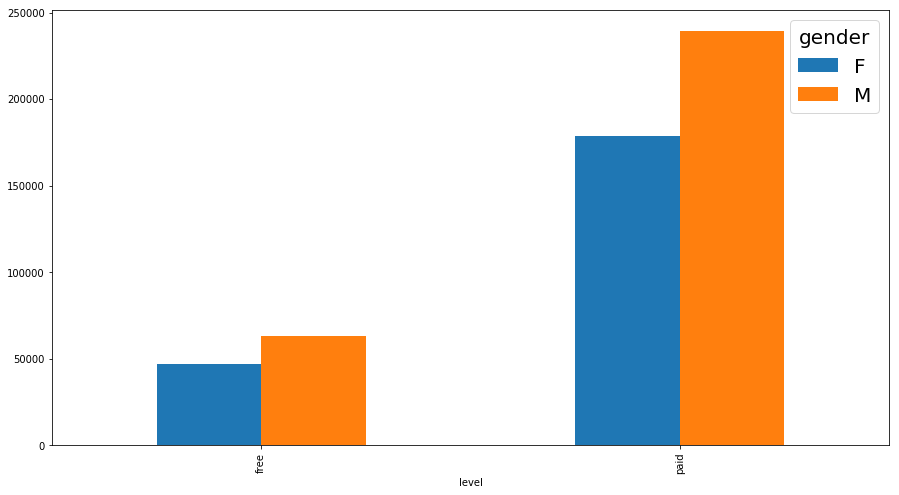

In [16]:
df_count = df.select('userId','gender','level').groupby('gender','level').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
df_count.pivot(index='level', columns='gender', values='count').plot(kind='bar', ax=ax)
# plt.savefig('gender_level.png')

In [17]:
df_churn = df.where("label==1")

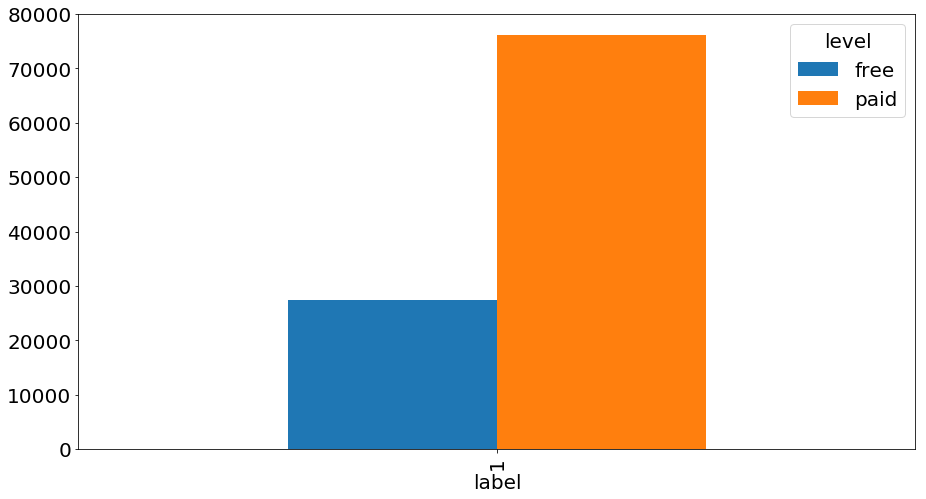

In [18]:
df_count_ = df_churn.select('userId','level','label').groupby('level','label').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
df_count_.pivot(index='label', columns='level', values='count').plot(kind='bar', ax=ax)
# plt.savefig('label_level.png')

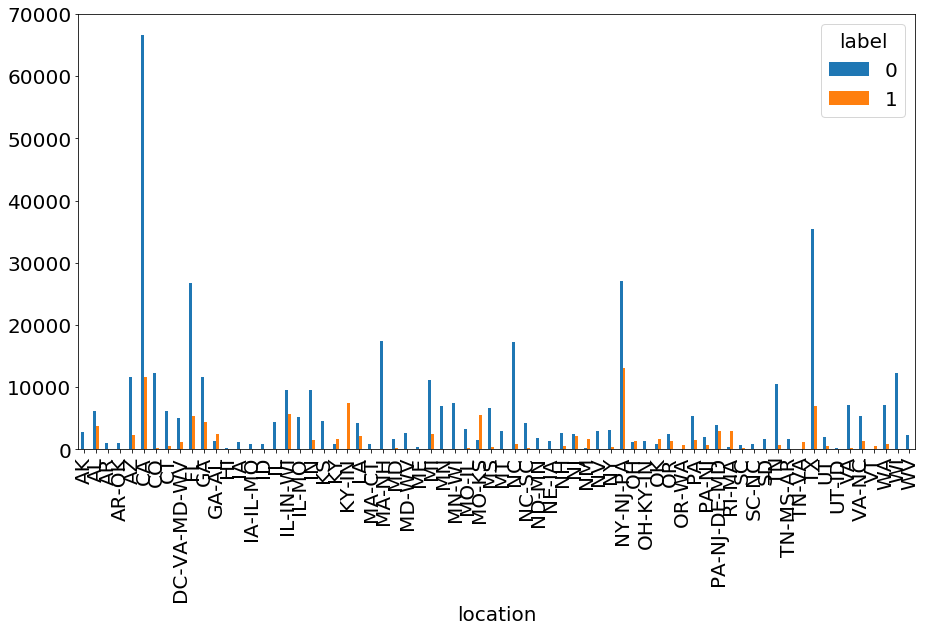

In [19]:
df_state_count_ = df.select('userId','location','label').groupby('location','label').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
df_state_count_.pivot(index='location', columns='label', values='count').plot(kind='bar', ax=ax)
# plt.savefig('state_churn.png')

